# Light 1 Numerical and Data Analysis Answers

In [1]:
%matplotlib notebook
import matplotlib
from astropy.table import Table
import requests

## 1. Find and plot optical spectra from SDSS of quasars, galaxies, and stars

There are a number of ways to gather spectra from SDSS. Here, we will first query CasJobs to find good spectra classified in each category. Then we will download their spectra using the SDSS SAS API.

In [2]:
from SciServer import CasJobs
from SciServer import Authentication
from io import StringIO

We will define a convenience function to find different types of objects.

In [3]:
def retrieve_objects(sclass='GALAXY'):
    # We define the columns we want and their 
    columns = ('ra', 'dec', 'z', 'class', 'plate', 'fiberid', 'mjd', 'run2d', 'run1d')
    dtypes= ('f8', 'f8', 'f4', 'S', 'i4', 'i4', 'i4', 'S', 'S')

    # Now define the query
    query = """
SELECT TOP 10 {columns}
FROM specObj 
WHERE class = '{sclass}' and zwarning = 0 and snmedian_r > 8
"""
    query = query.format(columns=', '.join(list(columns)), sclass=sclass)

    # Execute the query (requires internet access)
    responseStream = CasJobs.executeQuery(query, "DR12", format="dict")

    # convert result into astropy table
    result = responseStream['Result'][0]
    data = list(map(list, zip(*result['Data'])))
    objects = Table(data, names=columns, dtype=dtypes)
    return(objects)

Let's find some galaxies and show the information.

In [4]:
galaxies = retrieve_objects(sclass='GALAXY')
galaxies.show_in_notebook()

/Users/blanton/anaconda3/lib/python3.6/site-packages/SciServer-1.10.2-py3.6.egg/SciServer/CasJobs.py:116: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


idx,ra,dec,z,class,plate,fiberid,mjd,run2d,run1d
0,215.04742,25.345426,0.0788727,GALAXY,2128,575,53800,26,
1,214.60311,25.114103,0.01650546,GALAXY,2128,577,53800,26,
2,214.79685,25.173384,0.07925931,GALAXY,2128,578,53800,26,
3,215.07301,25.025921,0.06886992,GALAXY,2128,579,53800,26,
4,214.87019,24.678506,0.05472199,GALAXY,2128,581,53800,26,
5,214.78653,24.852944,0.1652594,GALAXY,2128,582,53800,26,
6,214.72779,24.974805,0.1762732,GALAXY,2128,584,53800,26,
7,214.69502,24.937002,0.01809064,GALAXY,2128,585,53800,26,
8,214.89442,24.812244,0.3367326,GALAXY,2128,586,53800,26,
9,214.75578,24.943717,0.01787376,GALAXY,2128,587,53800,26,


Now we will download and plot the spectrum of one of the galaxies. This cell will write a file into your local directory called galaxy.fits.

In [5]:
request_template = 'https://dr13.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberid}'
igalaxy = 5
request = request_template.format(plate=galaxies['plate'][igalaxy], fiberid=galaxies['fiberid'][igalaxy], mjd=galaxies['mjd'][igalaxy])
r = requests.get(request)
fp = open('galaxy.fits', 'wb')
fp.write(r.content)
fp.close()

Now we plot it. Note that "loglam" is the base-10 logarithm of the wavelength in Angstroms, and flux is in $10^{-17}$ erg/cm$^2$/s/A, for this particular spectrum. The broad underlying continuum light is due to stars. The sharp spikes upward are called emission lines and are emitted by ionized gas in between the stars. This particular spectrum has a fair amount of noise.

In [23]:
data = fitsio.read('galaxy.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Text(23.0694,0.5,'$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

We can smooth this spectrum. Here we choose to smooth the spectrum with a Gaussian with $R\sim 1000$ in terms of full-width half maximum. In $\log_{10}\lambda$ coordinates (i.e. what loglam is in) the FWHM is $(1/R/\ln 10)$. Therefore we should convolve with the Gaussian:

$$\frac{1}{\sqrt{2\pi} \sigma} \exp\left[\frac{1}{2} \frac{\Delta{\rm loglam}^2}{\sigma^2}\right]$$

where:

$$\sigma = \frac{1}{2\sqrt{2\ln 2}} \frac{1}{R\ln 10}$$

The code below creates a kernel with the same log wavelength scale as the data, corresponding to $R=1000$.

In [31]:
R = 1000
sigma = (1. / (2. * np.sqrt(2. * np.log(2)))) * (1./(R * np.log(10)))
dpix = data['loglam'][1] - data['loglam'][0]
kernel_npix = (np.int32(np.floor(10. * sigma / dpix)) // 2) * 2 + 1
kernel_xcen = np.float32(kernel_npix // 2)
kernel_x = (np.arange(kernel_npix) - kernel_xcen) * dpix
kernel = np.exp(- 0.5 * (kernel_x / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

<IPython.core.display.Javascript object>


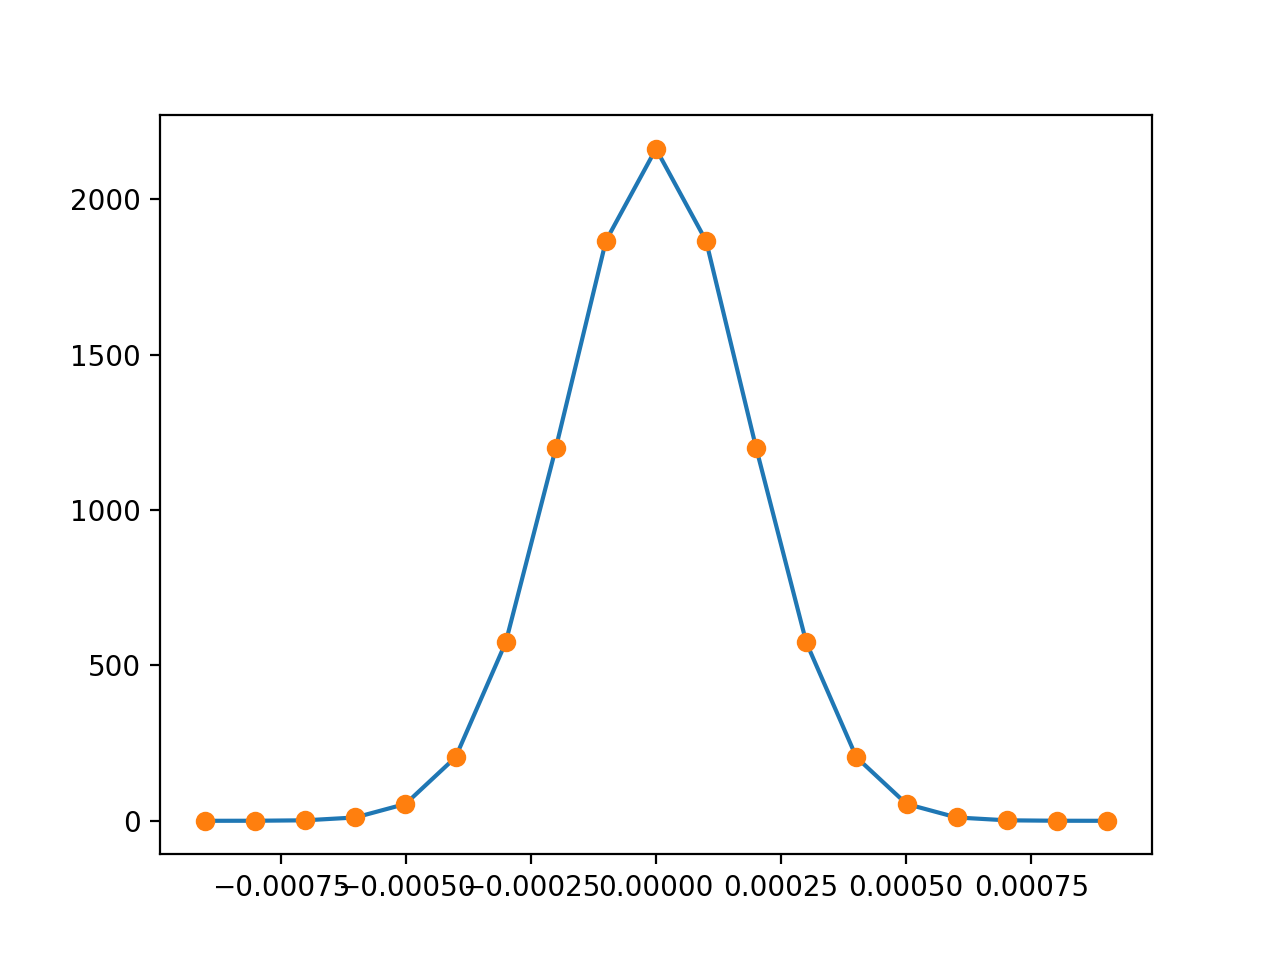

In [32]:
plt.plot(kernel_x, kernel)
plt.plot(kernel_x, kernel, 'o')

We can then convolve the flux with this kernel. We end up seeing the features of the galaxy spectrum at higher signal-to-noise, though also at lower resolution. (Note that in a statistical sense the pixels of the smoother spectrum now have strong off-diagonal covariances).

<IPython.core.display.Javascript object>


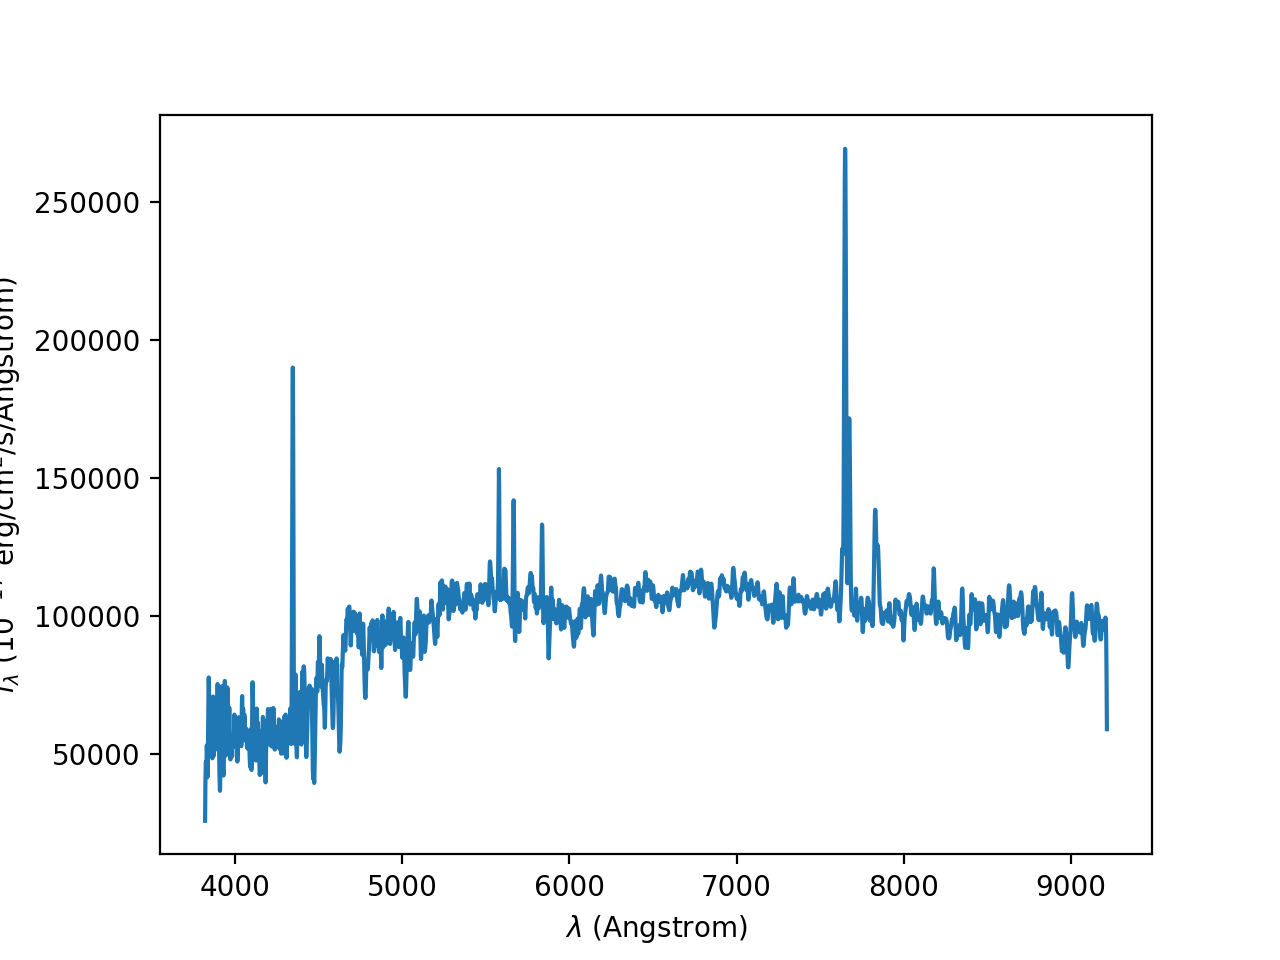

Text(0,0.5,'$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [34]:
sflux = np.convolve(data['flux'], kernel, mode='same')
plt.plot(10.**data['loglam'], sflux)
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now a quasar. In this case the very blue continuum is due to emission from the accretion disk surrounding the massive black hole. There are emission lines in this quasar but they are broad, because of the high random velocities of the emitting gas, which is within a few parsecs of the black hole.

/Users/blanton/anaconda3/lib/python3.6/site-packages/SciServer-1.10.2-py3.6.egg/SciServer/CasJobs.py:116: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


<IPython.core.display.Javascript object>


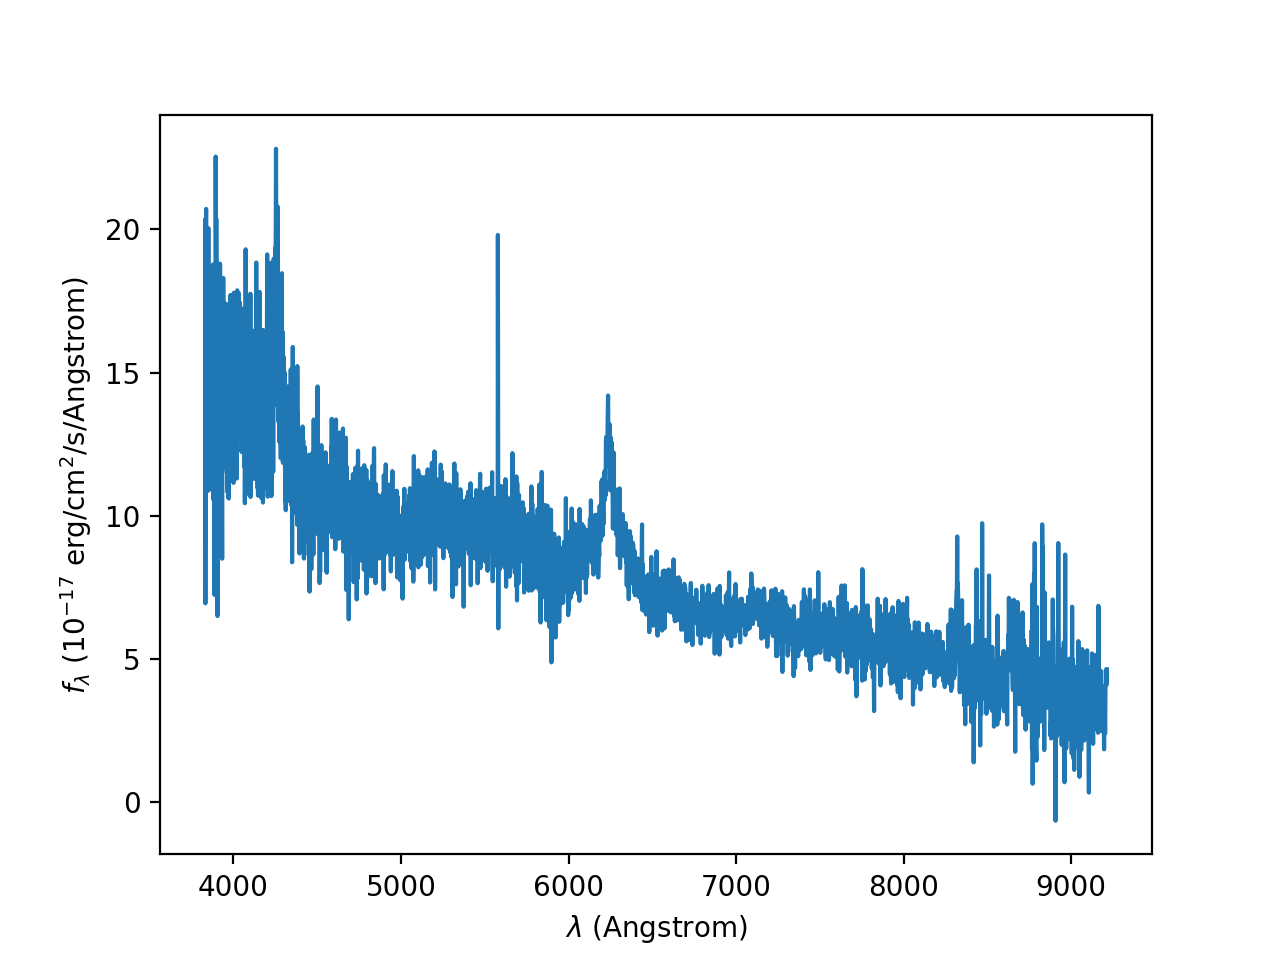

Text(0,0.5,'$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [7]:
qsos = retrieve_objects(sclass='QSO')
iqso = 5
request = request_template.format(plate=qsos['plate'][iqso], fiberid=qsos['fiberid'][iqso], mjd=qsos['mjd'][iqso])
r = requests.get(request)
fp = open('qso.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('qso.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Finally a star. This star is an A star. The Balmer line absorption sequence can clearly be seen.

/Users/blanton/anaconda3/lib/python3.6/site-packages/SciServer-1.10.2-py3.6.egg/SciServer/CasJobs.py:116: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


<IPython.core.display.Javascript object>


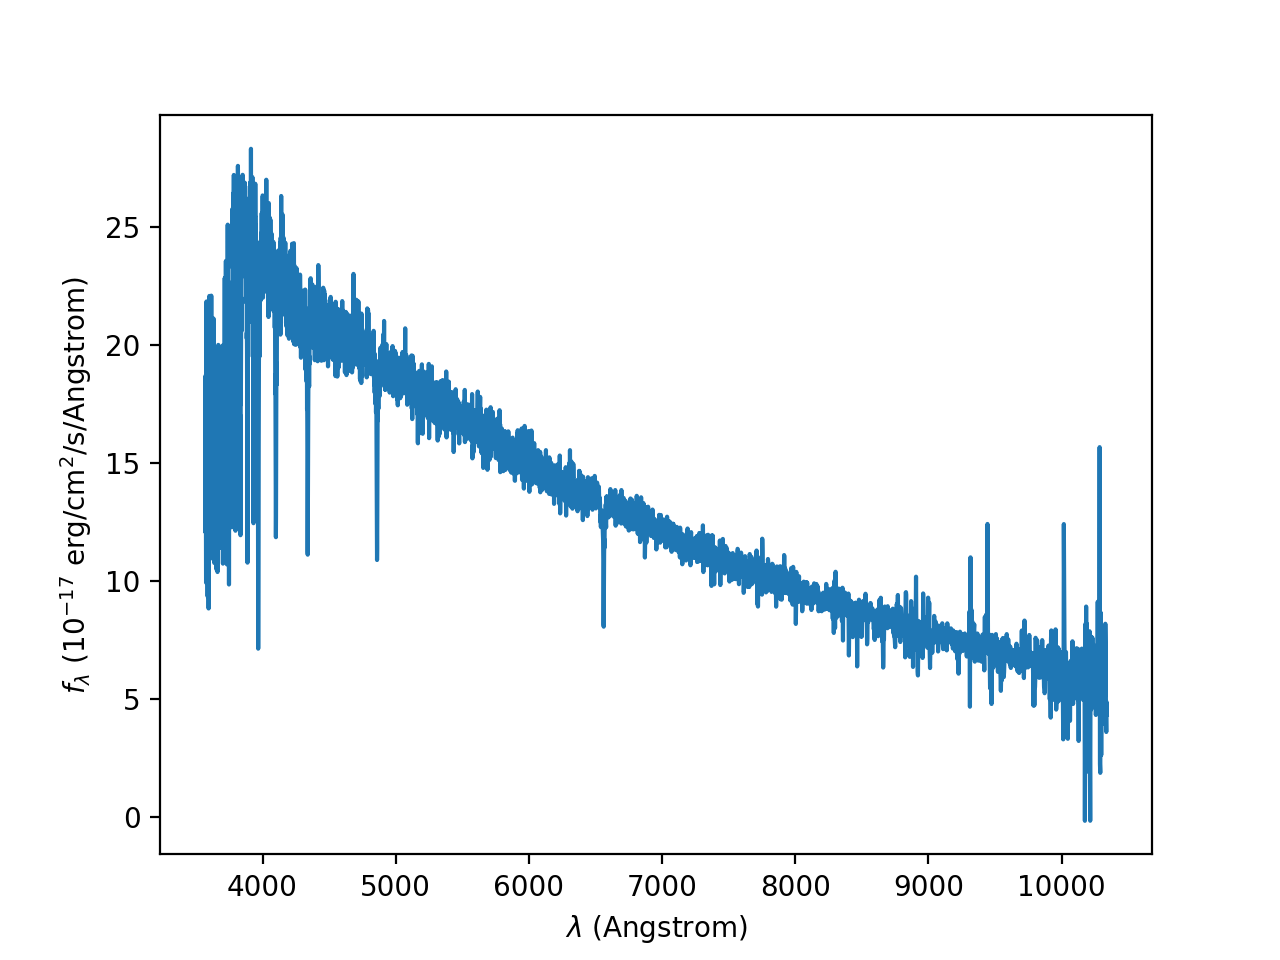

Text(0,0.5,'$f_\\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

In [8]:
stars = retrieve_objects(sclass='STAR')
istar = 5
request = request_template.format(plate=stars['plate'][istar], fiberid=stars['fiberid'][istar], mjd=stars['mjd'][istar])
r = requests.get(request)
fp = open('star.fits', 'wb')
fp.write(r.content)
fp.close()
data = fitsio.read('star.fits')
plt.plot(10.**data['loglam'], data['flux'])
plt.xlabel('$\lambda$ (Angstrom)')
plt.ylabel('$f_\lambda$ ($10^{-17}$ erg/cm$^2$/s/Angstrom)')

Now convert to $f_\nu$.

<IPython.core.display.Javascript object>


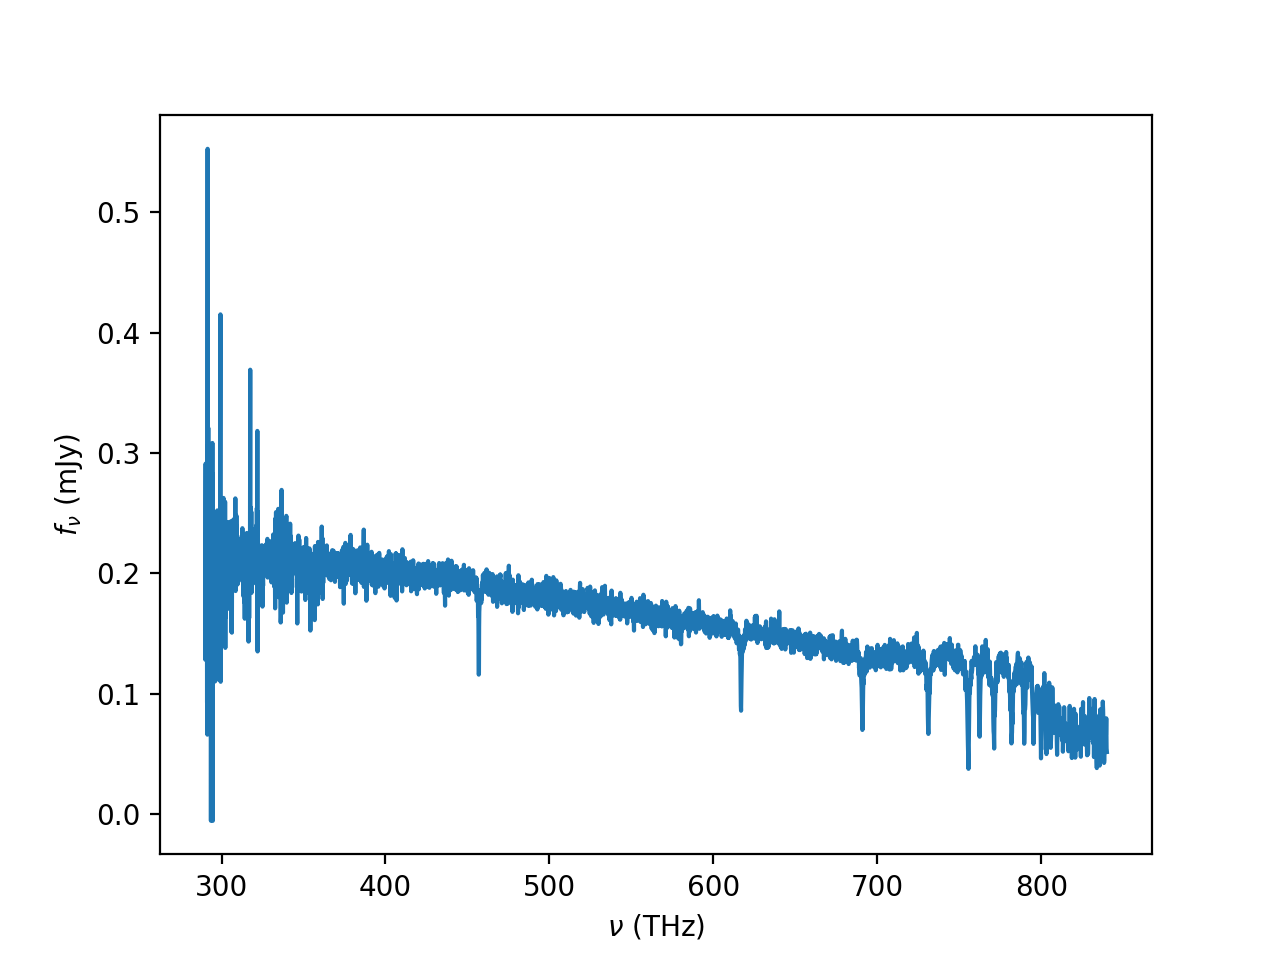

Text(0,0.5,'$f_\\nu$ (mJy)')

In [9]:
cspeed = 2.99792e+18 # Angstrom / s
nu = cspeed / 10.**data['loglam'] / 1.e+12 # into terahertz
fnu = data['flux'] * 10.**(2.*data['loglam']) / cspeed * (1.e-17 / 1.e-23 * 1.e+3) # into mJy
plt.plot(nu, fnu)
plt.xlabel(r'$\nu$ (THz)')
plt.ylabel(r'$f_\nu$ (mJy)')